In [25]:
import sys
from pathlib import Path
sys.path.append(str(Path("./multiscale-ssh")))  # replace with real path

from UNet import UNet  # or from unet import UNetSimple if you prefer the smaller version
from loss_function import CombinedLoss
from train_test import train_model
from train_test import evaluate_model

In [26]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
# import preprocessing
import os
import xrft
# import gcm_filters
import random

warnings.filterwarnings("ignore")

# importlib.reload(preprocessing)
# from preprocessing import preprocess_data

# from model_eval_plotting import evaluate_model
# from model_eval_plotting import plot_predictions_vs_targets

# from CNN_setup import SimpleCNN
# from CNN_setup import TensorDataset

# from gcm_filtering import filter_inputs_dataset
# from gcm_filtering import filter_inputs

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

# Data Pre-processing

In [27]:
ds_HR1 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_HR_southAtlantic_every10TimeSteps_yr1.zarr", engine="zarr", chunks={}
) 
ds_HR2 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_HR_southAtlantic_every10TimeSteps_yr2.zarr", engine="zarr", chunks={}
) 
ds_HR3 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_HR_southAtlantic_every10TimeSteps_yr3.zarr", engine="zarr", chunks={}
) 
ds_HR4 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_HR_southAtlantic_every10TimeSteps_yr4.zarr", engine="zarr", chunks={}
) 
ds_HR5 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_HR_southAtlantic_every10TimeSteps_yr5.zarr", engine="zarr", chunks={}
) 
datasets = [ds_HR1, ds_HR2, ds_HR3, ds_HR4, ds_HR5]

# Concatenate along the 'time' dimension
combined_HR = xr.concat(datasets, dim='time')
combined_HR

<xarray.Dataset> Size: 109MB
Dimensions:   (time: 185, yt_ocean: 163, xt_ocean: 150)
Coordinates:
  * time      (time) object 1kB 0181-01-01 12:00:00 ... 0185-12-26 12:00:00
  * xt_ocean  (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean  (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
Data variables:
    q_ref     (time, yt_ocean, xt_ocean) float32 18MB dask.array<chunksize=(19, 82, 75), meta=np.ndarray>
    slp       (time, yt_ocean, xt_ocean) float32 18MB dask.array<chunksize=(19, 82, 75), meta=np.ndarray>
    sst       (time, yt_ocean, xt_ocean) float32 18MB dask.array<chunksize=(19, 82, 75), meta=np.ndarray>
    t_ref     (time, yt_ocean, xt_ocean) float32 18MB dask.array<chunksize=(19, 82, 75), meta=np.ndarray>
    u_rel     (time, yt_ocean, xt_ocean) float32 18MB dask.array<chunksize=(19, 82, 75), meta=np.ndarray>
    v_rel     (time, yt_ocean, xt_ocean) float32 18MB dask.array<chunksize=(19, 82, 75), meta=np.ndarray>

In [28]:
# Note that all this data is LR because it is filtered

ds_train1 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps_yr1.zarr", engine="zarr", chunks={}
) 
ds_train2 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps_yr2.zarr", engine="zarr", chunks={}
) 
ds_train3 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps_yr3.zarr", engine="zarr", chunks={}
) 
ds_train4 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps_yr4.zarr", engine="zarr", chunks={}
) 
ds_train5 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps_yr5.zarr", engine="zarr", chunks={}
) 
datasets = [ds_train1, ds_train2, ds_train3, ds_train4, ds_train5]

# Concatenate along the 'time' dimension
combined_LR = xr.concat(datasets, dim='time')
combined_LR

<xarray.Dataset> Size: 217MB
Dimensions:   (time: 185, yt_ocean: 163, xt_ocean: 150)
Coordinates:
  * time      (time) object 1kB 0181-01-01 12:00:00 ... 0185-12-26 12:00:00
  * xt_ocean  (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean  (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
Data variables:
    q_ref     (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    slp       (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    sst       (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    t_ref     (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    u_rel     (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    v_rel     (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>

# Prepare Training/Testing Data

In [29]:
# Total number of samples
n_samples = len(combined_HR.time)  # Assuming 'time' is the dimension

# Generate random indices
indices = np.arange(n_samples)
np.random.shuffle(indices)

# Split indices for training, validation, and testing
train_size = int(0.7 * n_samples)
val_size = int(0.15 * n_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Select data using the indices
# HR
train_data_HR = combined_HR.isel(time=train_indices)
val_data_HR = combined_HR.isel(time=val_indices)
test_data_HR = combined_HR.isel(time=test_indices)
# LR
train_data_LR = combined_LR.isel(time=train_indices)
val_data_LR = combined_LR.isel(time=val_indices)
test_data_LR = combined_LR.isel(time=test_indices)

print("Training set size:", len(train_data_HR.time))
print("Validation set size:", len(val_data_HR.time))
print("Testing set size:", len(test_data_HR.time))

Training set size: 129
Validation set size: 27
Testing set size: 29


In [30]:
# Extract HR data
urel_HR_train = train_data_HR.u_rel.values ## training
urel_HR_val = val_data_HR.u_rel.values ## validation
urel_HR_test = test_data_HR.u_rel ## testing

# Extract LR data
urel_LR_train = train_data_LR.u_rel.values ## training
urel_LR_val = val_data_LR.u_rel.values ## validation
urel_LR_test = test_data_LR.u_rel.values ## testing

# Training U-Net

In [31]:
x_train = torch.tensor(urel_LR_train, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
y_train = torch.tensor(urel_HR_train, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

x_val = torch.tensor(urel_LR_val, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
y_val = torch.tensor(urel_HR_val, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

x_test = torch.tensor(urel_LR_test, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
# y_test = torch.tensor(urel_HR_test, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

In [32]:
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, torch.zeros(len(x_test)))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [33]:
model = UNet()
model

UNet(
  (enc_conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv1_1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv2_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [34]:
criterion = CombinedLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model.pth',
            n_epochs=10) # n_epochs=2000)

Trainable Parameters: 2314881
Epoch 1, Train Loss: 3.423e+01, Val Loss: 3.531e+01, Epoch Time: 73.31s
Model saved at epoch 1
Epoch 2, Train Loss: 2.653e+01, Val Loss: 3.235e+01, Epoch Time: 74.89s
Model saved at epoch 2
Epoch 3, Train Loss: 2.452e+01, Val Loss: 2.970e+01, Epoch Time: 71.61s
Model saved at epoch 3
Epoch 4, Train Loss: 2.325e+01, Val Loss: 2.782e+01, Epoch Time: 72.51s
Model saved at epoch 4
Epoch 5, Train Loss: 2.259e+01, Val Loss: 2.299e+01, Epoch Time: 70.98s
Model saved at epoch 5
Epoch 6, Train Loss: 2.179e+01, Val Loss: 2.224e+01, Epoch Time: 71.97s
Model saved at epoch 6
Epoch 7, Train Loss: 2.116e+01, Val Loss: 1.933e+01, Epoch Time: 73.10s
Model saved at epoch 7
Epoch 8, Train Loss: 2.064e+01, Val Loss: 1.902e+01, Epoch Time: 73.53s
Model saved at epoch 8
Epoch 9, Train Loss: 2.008e+01, Val Loss: 1.781e+01, Epoch Time: 72.42s
Model saved at epoch 9
Epoch 10, Train Loss: 1.960e+01, Val Loss: 1.644e+01, Epoch Time: 71.42s
Model saved at epoch 10
Training complete


# Testing U-Net

In [35]:
bm_pred, ubm_pred = evaluate_model(model, device, test_loader, urel_HR_test, './model.pth')

Loaded model parameters from ./model.pth


In [36]:
sgs_pred = ubm_pred
hr_pred = bm_pred + ubm_pred
hr_pred

<xarray.DataArray (time: 29, yt_ocean: 163, xt_ocean: 150)> Size: 3MB
dask.array<add, shape=(29, 163, 150), dtype=float32, chunksize=(18, 82, 75), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 232B 0185-02-09 12:00:00 ... 0181-02-20 12:00:00
  * xt_ocean  (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean  (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07

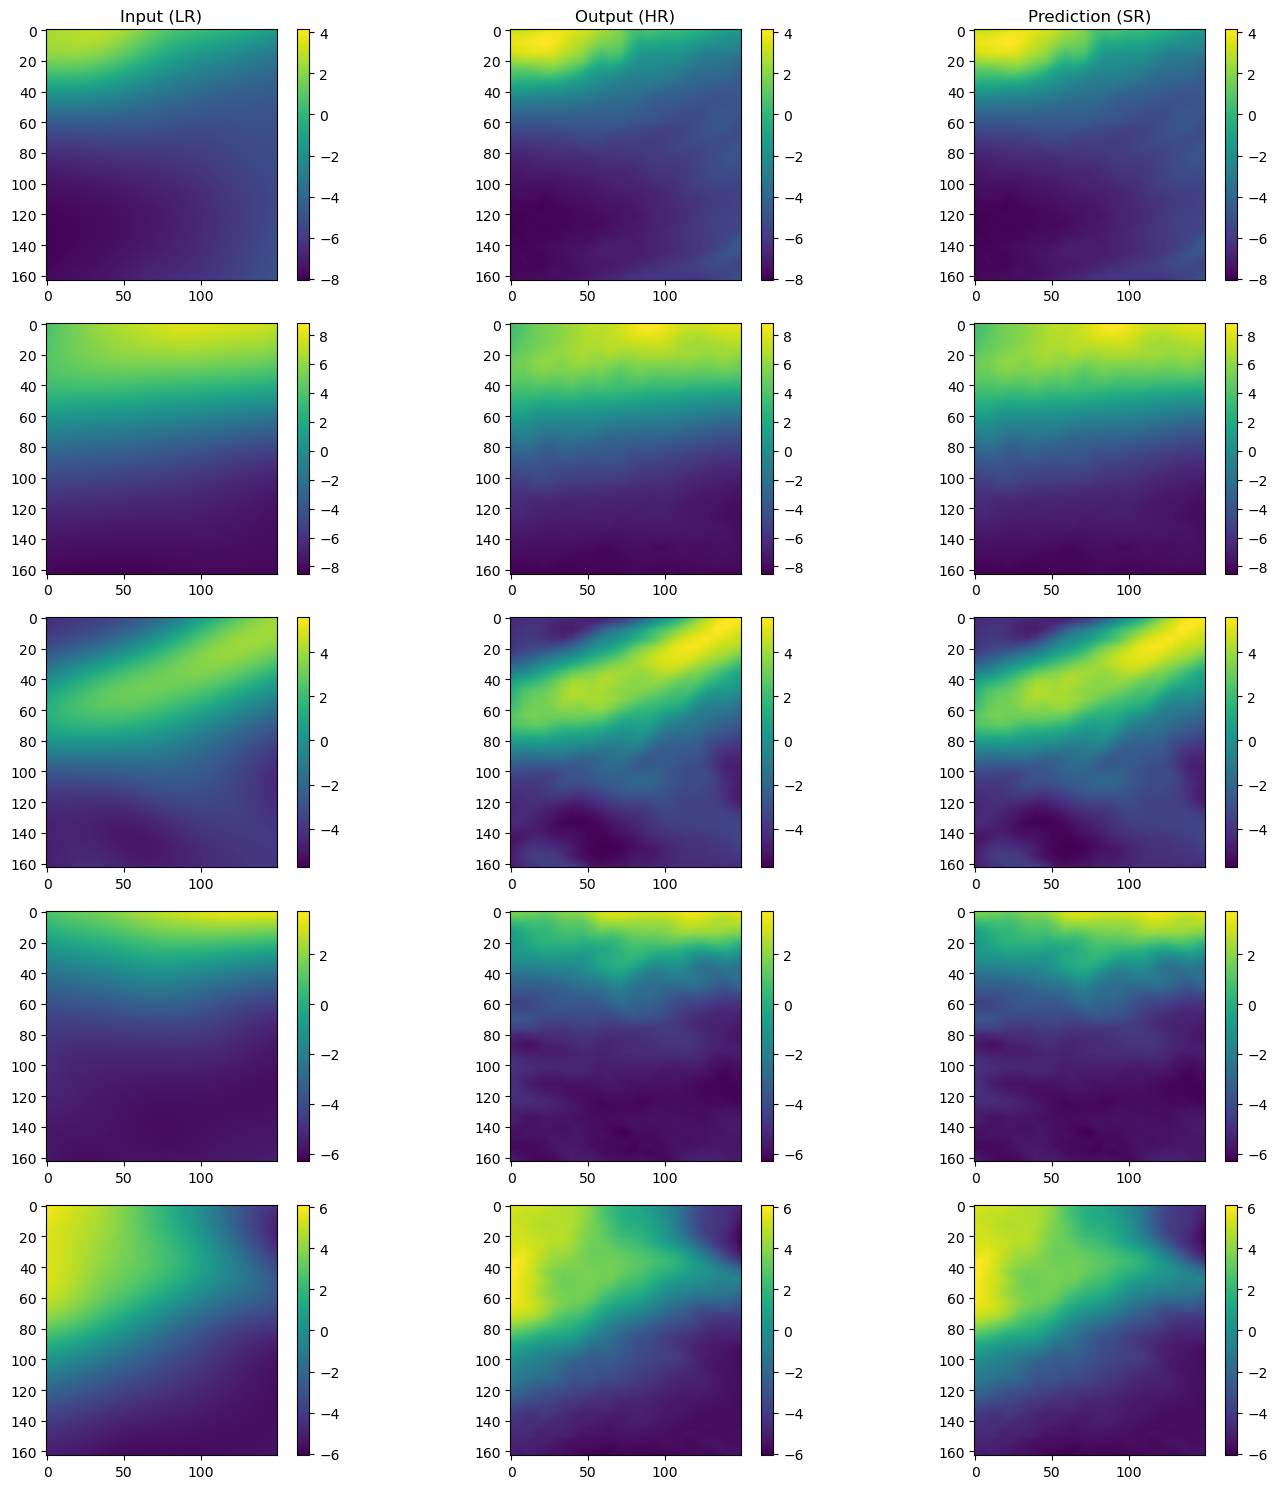

In [54]:
num_samples = 5

# Create figure with 5 rows and 3 columns
fig, axs = plt.subplots(num_samples, 3, figsize=(15, 3 * num_samples))

# Now plot all images with shared vmin/vmax
for i in range(num_samples):
    d1 = urel_LR_test[i,:,:] 
    d2 = urel_HR_test[i,:,:]
    d3 = hr_pred[i,:,:]

    # Min/Max Calculation
    vmin = min(d1.min().compute().item(), d2.min().compute().item(), d3.min().compute().item())
    vmax = max(d1.max().compute().item(), d2.max().compute().item(), d3.max().compute().item())
    
    # Input (LR)
    im1 = axs[i, 0].imshow(d1, cmap='viridis', vmin=vmin, vmax=vmax)
    if i == 0:
        axs[i, 0].set_title('Input (LR)')
    plt.colorbar(im1, ax=axs[i, 0], fraction=0.046, pad=0.04)

    # Output (HR)
    im2 = axs[i, 1].imshow(d2, cmap='viridis', vmin=vmin, vmax=vmax)
    if i == 0:
        axs[i, 1].set_title('Output (HR)')
    plt.colorbar(im2, ax=axs[i, 1], fraction=0.046, pad=0.04)

    # Prediction (SR)
    im3 = axs[i, 2].imshow(d3, cmap='viridis', vmin=vmin, vmax=vmax)
    if i == 0:
        axs[i, 2].set_title('Prediction (SR)')
    plt.colorbar(im3, ax=axs[i, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [60]:
hr_pred.mean(dim='time')

<xarray.DataArray (yt_ocean: 163, xt_ocean: 150)> Size: 98kB
dask.array<mean_agg-aggregate, shape=(163, 150), dtype=float32, chunksize=(82, 75), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean  (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07

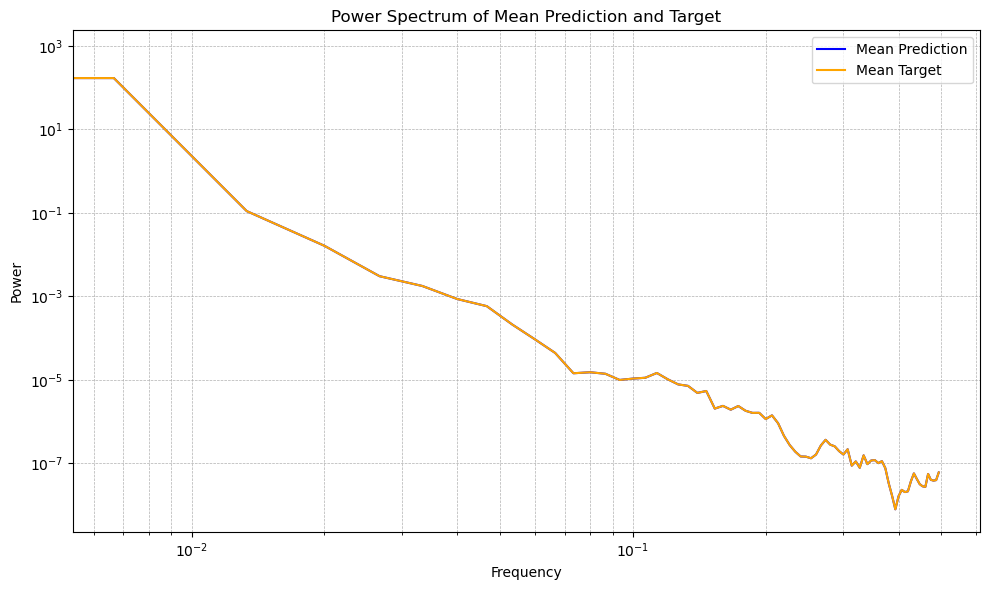

In [63]:
# Define dimensions and coordinates
dims = ['yt_ocean', 'xt_ocean']
coords = {
    'yt_ocean': range(hr_pred.shape[-2]),  # Replace with actual coordinates if available
    'xt_ocean': range(hr_pred.shape[-1])   # Replace with actual coordinates if available
}

# Compute the mean prediction and target across samples
mean_prediction = hr_pred.mean(dim='time')  # Squeeze to remove the channel dimension and compute mean
mean_target = urel_HR_test.mean(dim='time')

# Convert to xarray.DataArray
mean_prediction_da = xr.DataArray(mean_prediction, dims=dims, coords=coords)
mean_target_da = xr.DataArray(mean_target, dims=dims, coords=coords)

mean_prediction_da = mean_prediction_da.chunk({'xt_ocean': -1})  # one chunk along xt_ocean
mean_target_da = mean_target_da.chunk({'xt_ocean': -1})

# Compute power spectrum for mean prediction and target
ps_pred = xrft.power_spectrum(mean_prediction_da, dim='xt_ocean', window=True).mean(dim='yt_ocean')
ps_targ = xrft.power_spectrum(mean_target_da, dim='xt_ocean', window=True).mean(dim='yt_ocean')

# Plot power spectra
plt.figure(figsize=(10, 6))
plt.plot(ps_pred.freq_xt_ocean, ps_pred, label='Mean Prediction', color='blue')
plt.plot(ps_targ.freq_xt_ocean, ps_targ, label='Mean Target', color='orange')

# Configure the plot
plt.title("Power Spectrum of Mean Prediction and Target")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend(loc='best')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()

# Display the plot
plt.show()


# Error Analysis

In [65]:
predictions = hr_pred
dims = ['sample', 'yt_ocean', 'xt_ocean']
coords = {
    'sample': range(predictions.shape[0]),
    'yt_ocean': range(predictions.shape[-2]),  
    'xt_ocean': range(predictions.shape[-1])
}
prediction_da = xr.DataArray(predictions, dims=dims, coords=coords)
prediction_da

<xarray.DataArray (sample: 29, yt_ocean: 163, xt_ocean: 150)> Size: 3MB
dask.array<add, shape=(29, 163, 150), dtype=float32, chunksize=(18, 82, 75), chunktype=numpy.ndarray>
Coordinates:
  * sample    (sample) int64 232B 0 1 2 3 4 5 6 7 8 ... 21 22 23 24 25 26 27 28
  * yt_ocean  (yt_ocean) int64 1kB 0 1 2 3 4 5 6 ... 156 157 158 159 160 161 162
  * xt_ocean  (xt_ocean) int64 1kB 0 1 2 3 4 5 6 ... 143 144 145 146 147 148 149

In [66]:
targets = urel_HR_test
dims = ['sample', 'yt_ocean', 'xt_ocean']
coords = {
    'sample': range(targets.shape[0]),
    'yt_ocean': range(targets.shape[-2]),  
    'xt_ocean': range(targets.shape[-1])
}
target_da = xr.DataArray(targets, dims=dims, coords=coords)
target_da

<xarray.DataArray 'u_rel' (sample: 29, yt_ocean: 163, xt_ocean: 150)> Size: 3MB
dask.array<getitem, shape=(29, 163, 150), dtype=float32, chunksize=(18, 82, 75), chunktype=numpy.ndarray>
Coordinates:
  * sample    (sample) int64 232B 0 1 2 3 4 5 6 7 8 ... 21 22 23 24 25 26 27 28
  * yt_ocean  (yt_ocean) int64 1kB 0 1 2 3 4 5 6 ... 156 157 158 159 160 161 162
  * xt_ocean  (xt_ocean) int64 1kB 0 1 2 3 4 5 6 ... 143 144 145 146 147 148 149

In [67]:
def r2_score(y_true, y_pred):
    y_true = y_true.values.flatten()
    y_pred = y_pred.values.flatten()
    y_true_mean = np.mean(y_true)
    ss_total = np.sum((y_true - y_true_mean) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    return 1 - ss_res / ss_total

def r_corr(y_true, y_pred):
    y_true = y_true.values.flatten()
    y_pred = y_pred.values.flatten()
    y_true_mean = np.mean(y_true)
    y_pred_mean = np.mean(y_pred)
    vx = y_true - y_true_mean
    vy = y_pred - y_pred_mean
    return np.sum(vx * vy) / (np.sqrt(np.sum(vx ** 2)) * np.sqrt(np.sum(vy ** 2)))

In [68]:
r2 = r2_score(target_da, prediction_da)
r2

np.float32(1.0)

In [69]:
corr = r_corr(target_da, prediction_da)
corr

np.float32(0.9999999)

In [70]:
# Per pixel mean absolute error (MAE) statistics

# y_true and y_pred are numpy arrays of shape (N, H, W)
# N: number of samples, H: height, W: width

# 1. Compute absolute errors (N, H, W)
abs_errors = np.abs(target_da - prediction_da)

# 2. For each pixel (h,w), get distribution over N samples
# Example stats:

# Mean absolute error per pixel: shape (H, W)
mae_per_pixel = np.mean(abs_errors, axis=0)

# Median absolute error per pixel
median_ae_per_pixel = np.median(abs_errors, axis=0)

# Std deviation of absolute error per pixel
std_ae_per_pixel = np.std(abs_errors, axis=0)

In [71]:
flat_mae = mae_per_pixel.values.flatten()

summary = {
    'Mean MAE': np.mean(flat_mae),
    'Median MAE': np.median(flat_mae),
    'Std MAE': np.std(flat_mae),
    'Min MAE': np.min(flat_mae),
    'Max MAE': np.max(flat_mae),
    '25th Percentile': np.percentile(flat_mae, 25),
    '75th Percentile': np.percentile(flat_mae, 75)
}

summary

{'Mean MAE': np.float32(2.9265989e-08),
 'Median MAE': np.float32(2.0553326e-08),
 'Std MAE': np.float32(2.6607259e-08),
 'Min MAE': np.float32(0.0),
 'Max MAE': np.float32(1.9731193e-07),
 '25th Percentile': np.float32(8.22133e-09),
 '75th Percentile': np.float32(4.9327983e-08)}